# Fundamentals of Computer Science 30398 - Lecture 15

In this and the next (bonus) lecture, we will have our first look at machine learning techniques. You will see much more detailed expositions of those concepts in subsequent courses, as you gain more programming skills and extend your mathematical toolkit - including a course focused solely on Machine Learning.

For this first encounter with machine learning, the programming part will not require anything beyond what you have already learned at this course; the entire project is only slightly more complex than some of the larger exercises we have covered. As for the necessary mathematical background - many of the concepts needed to fully appreciate what happens here you will study in details in mathematics courses - most importantly the notion of derviative of a multivariate function $f : \mathbb{R}^n \to \mathbb{R}$ (specifically, a gradient of such function); I will provide in those two lectures bits of intuition, as well as motivation to understand this, when you will have covered it in details in a more abstract setting.

### How to read/execute those notes
In this lecture we will start by discussing the high-level idea of what we are doing, and what is the end-goal of our program. That will include presenting several plots that are generated by a code that will not be provided in the introduction. If you want to look at the code that was used to produce all those plots in the intro, it is attached as the section **Additional functions** at the end of the notebook. If you want to execute all this code yourself, start by evaluating all the cells in this last section; then you can go step-by-step over this notebook.

In this, and the next lecture notes, we will then write all necessary functions step-by-step, together with most of the code used for visualization; by the end, you will be able to recreate all those plots, and interact with with the code to see what happens when you change some things.

## Supervised learning: binary classification

One of the most typical scenario for machine learning, and classically most heavily studied, is the supervised learning problem of classification (a motivating example to keep in mind is image classification). For simplicity we will consider a binary classification problem, where we only have two classes.

Such a learning problem consist of two phases: _training_, when the algorithm is provided a (huge) database of already labeled examples; for example a huge collection of pictures of cats and dogs, each with a label: is it a cat, or a dog, as below:

### Training:

![cat](pictures/cat-1.png) <span style='font-size: 30px'>Label: 0</span>

![cat](pictures/cat-2.png): <span style='font-size: 30px'>Label: 0</span>

![cat](pictures/dog-1.png): <span style='font-size: 30px'>Label: 1</span>

...

![cat](pictures/cat-3.png): <span style='font-size: 30px'>Label: 0</span>

![cat](pictures/dog-2.png): <span style='font-size: 30px'>Label: 1</span>

![cat](pictures/cat-4.png): <span style='font-size: 30px'>Label: 0</span>

![cat](pictures/cat-5.png): <span style='font-size: 30px'>Label: 0</span>


By processing this large dataset (the _training phase_), the training algorithm tries to come up with a _classifier_. This classifier then is applied to new examples, from the same distribution as the training examples (but - crucially - examples than do not necessairly show up in the training dataset), and attempts to answer to which class this new example belongs:

### Classification:
(![cat](pictures/dog-5.png): <span style='font-size: 30px'>Label: ?</span>

## Two dimensional example

How does the training work? Let's focus on a simple two-dimensional example. Here, my cats, and dogs are not necessairly the high-resolution pictures, but just point on a plane (each point with two coordinates). By itself this geometric rephrasing of the problem is actually valid also for the image classification problem above; we can treat a $100 \times 100$ pixels large gray-scale image, just as an point in a space of dimension $100 \times 100$ (each coordinate of which is given by the intensity of the particular pixel). Since it is hard to draw things in $10^4$ dimension, let us start with $2$.

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np

Let's say that cats are just points generated from a Gaussian distribution around mean $(1., 3.)$, and dogs, points generated from a Gaussian distribution around mean $(-2., 1.)$.

In [10]:
cats = np.random.normal(loc = [1.0, 3.0], size = (100, 2))
dogs = np.random.normal(loc = [-2., 1.], size = (100, 2))

We can visualize them on a single plot.

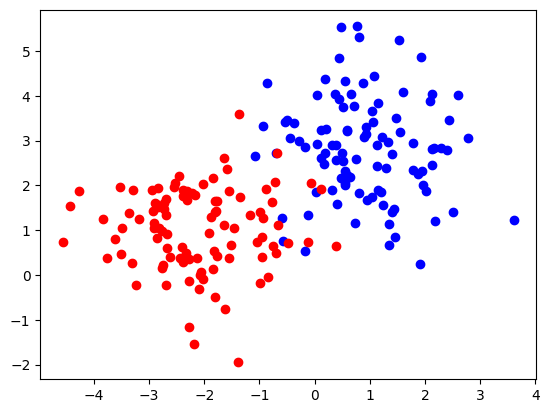

In [11]:
plt.scatter(cats[:, 0], cats[:, 1], color="blue")
plt.scatter(dogs[:, 0], dogs[:, 1], color="red")

Of course, if this was a training set, we can just look at the scatter-plot, and figure out what is supposed to be a classifier for new points: we would draw a line, mostly separating red from blue points, and when a new point comes along, if it's on the right hand side of the line, we classify it as a cat, if it's on the left hand side - we classify it as a dog.

In higher dimension the "just look at the scatter plot" algorithm isn't neccessairly going to work, so we might ask ourselfs, how to find algorithmically line that separates the training points as well as possible.

As it will turn out, we will not actually use a classifier that simply maps everything on the left of a line to a class $0$, and everything on the right to a class $1$. Instead, the classifier that we will use, will be a bit "smoother" one: we will attempt find some line (together with a "scaling" parameter) such that the point far enough from this line to the left will be given class very close to 1, points far enough to the right will be given class $0$, points on the line exactly will be given class $0.5$, and the classifier behaves "smoothly" in between.

That is, the classifier will first project a point a given point onto some direction (perpendicular to the separation line), shift a bit if necessary, and then apply the sigmoid function
$$
\sigma(x) := \frac{e^{x}}{e^{x} + 1}
$$

In [12]:
def sigmoid(x):
    return np.exp(x) / ( 1 + np.exp(x) )

The plot of sigmoid function looks like that:

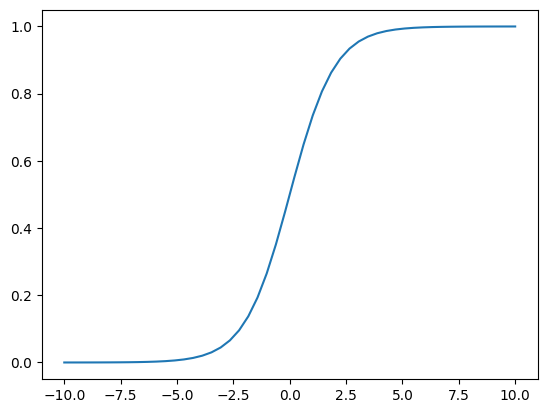

In [13]:
x = np.linspace(-10, 10)
plt.plot(x, sigmoid(x))

Things very far to the right have value close to $1$, and far to the left have value close to $0$. So the famil of classifiers we consider consists of functions that take $x \in \mathbb{R}^2$ and output a value $f(x) \in [0, 1]$, that look like this:

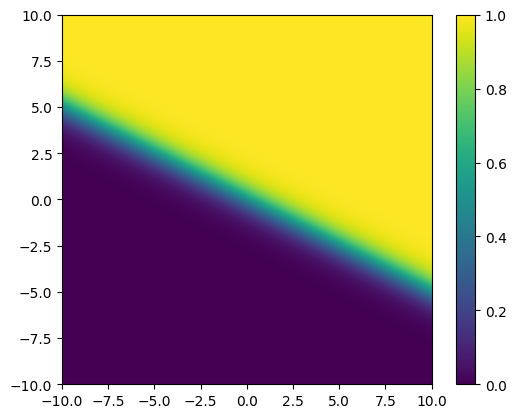

In [15]:
extent = [-10, 10, -10, 10]
plot_2d_func(lambda x: classifier(x, np.array([1., 2., 0.])), extent=extent, N = 200)
plt.colorbar()

Or this:

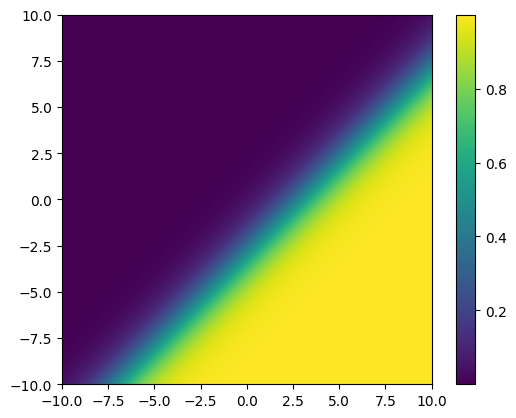

In [17]:
plot_2d_func(lambda x: classifier(x, np.array([1., -1., -3.])), extent=extent, N = 200)
plt.colorbar()

Now, as will turn out, all the classifying functions in our family can be _parametrized_ by a single vector $\theta \in \mathbb{R}^3$ (i.e. we can use $3$ numbers to specify a function like above - this is similar to the standard parametrization of lines on a plane). For every fixed $\theta$ (which correspond to a given classifier $f_{\theta} : \mathbb{R}^2 \to [0, 1]$), we can compute a _loss_ of $f_\theta$ on a training dataset (we will discuss it in more details in the next lecture). Intuitively, the loss just captures how many of the training examples are misclasified, and how badly.

### What really is training?

If we phrase the problem like this, the "training" phase of machine learning algorithm will often just correspond to attempting to find a parameter $\theta$, that yields as small loss on the training dataset as possible. We can now abstract this away: we can think of a function $\mathrm{training\_loss}(\theta) \to \mathbb{R}_{\geq 0}$ that takes as an argument $\theta \in \mathbb{R}^3$ (a parameter specifying a concrete specifier), and outputs its loss on the training dataset. The training problem is now just

Find $\theta \in \mathbb{R}^3$ that minimizes $\mathrm{training\_loss}(\theta)$. This problem is generally computationally hard, especially in high dimension (altought it becomes tractable, in particular when function $\mathrm{training\_loss}$ is _convex_, and satisfies some other mild assumptions). 

One of the common techniques (usually: a heuristic) to attempt to solve those types of problems is a variant of a _gradient descent_ algorithm (this algorithm, and its further improvements, is actually an underlying workhorse behind all of the machine learning we see today!). Instead of trying to actually find $\theta$ that _globally_ minimizes the function $\mathrm{traninig\_loss}$, we will try to fine some decent $\theta$ by an iterative technique: 
1. Start with any (often: random) $\theta_0$.
2. Check what is the training loss at this $\theta_0$ (usually bad)
3. Try to perturb slightly $\theta_0$ such that the loss gets smaller: move it slightly in the direction, in which the function $\mathrm{training\_loss}$ decreases the fastest _locally_.
4. Repeat this as long as you are making some progress.
We can rarely guarantee that such a procedure finds actual global minimum $\theta$ we are looking for, but under relatively mild conditions this will eventually converge to a _local minimum_: a point $\theta$ s.t. any local perturbation of $\theta$ yields a larger loss.

As it turns out, in some applications (most notably: in the loss minimization for deep neural networks) the local minimum we find is often good enough: both the value of the training loss function is small at the local minimum, but also - more importantly - the classifier we find behaves well on new examples.

### Training linear classifier on the two dimensional example

Let us go back to the two dimensional example we were looking at, with the classifiers as above - some line separation, composed with the sigmoid function. How the iterative procedure could look like?

We start with a completely random classifier:

In [80]:
start_theta = np.random.normal(size=3)

It doesn't do anything particularly useful on the training set:

In [81]:
def plot_classifier(theta, cats, dogs, extent=[-10, 10, -10, 10]):
    plot_2d_func(lambda x: classifier(x, theta), extent=extent, N = 200)
    plt.scatter(cats[:, 0], cats[:, 1], color="blue")
    plt.scatter(dogs[:, 0], dogs[:, 1], color="red")
    plt.colorbar()

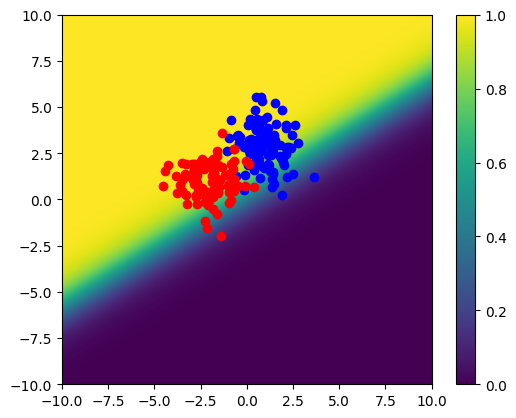

In [83]:
plot_classifier(start_theta, cats, dogs, extent=extent)

Let's run a sequence of local improvements:

In [84]:
dataset = [(x, 0) for x in cats] + [(x, 1) for x in dogs]

In [85]:
steps = gradient_descent(start_theta, lambda theta: grad_total_loss(theta=theta, dataset=dataset),mu=0.001, iters=1000)

After a first steps, it moves slightly closer to correct:

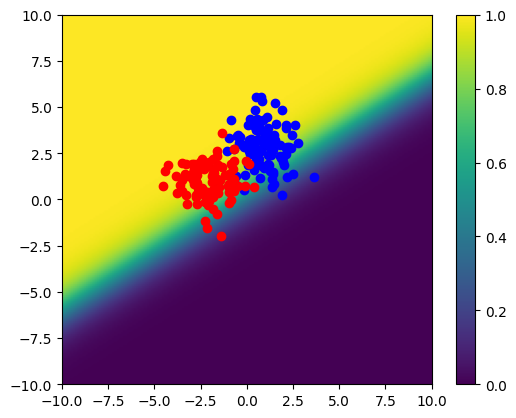

In [91]:
plot_classifier(steps[1], cats, dogs, extent=extent)

Afer a second step, closer stilll:

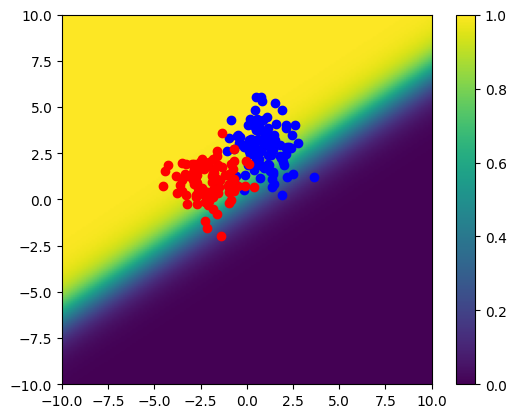

In [92]:
plot_classifier(steps[2], cats, dogs, extent=extent)

After 15 steps, we start seeing some alignment with the right separation

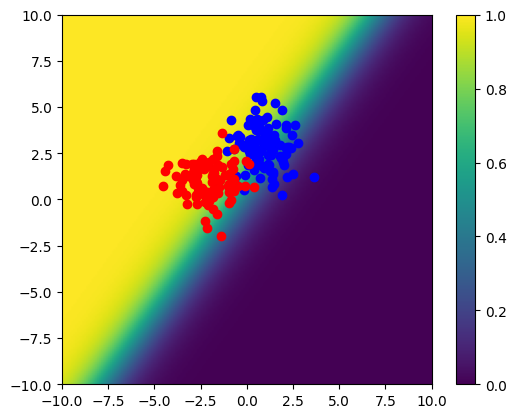

In [94]:
plot_classifier(steps[15], cats, dogs, extent=extent)

After $30$ steps, the alignment is already quite strong

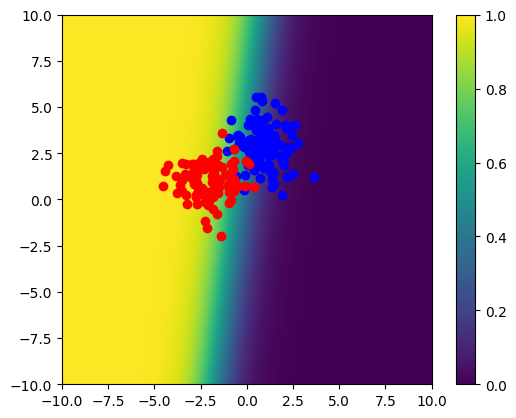

In [96]:
plot_classifier(steps[30], cats, dogs, extent=extent)

And finally, after $1000$ steps we have essentially found the correct separation, and increased the confidence: the interval in which the values are far from either $0$ and $1$ has shrunk a bit:

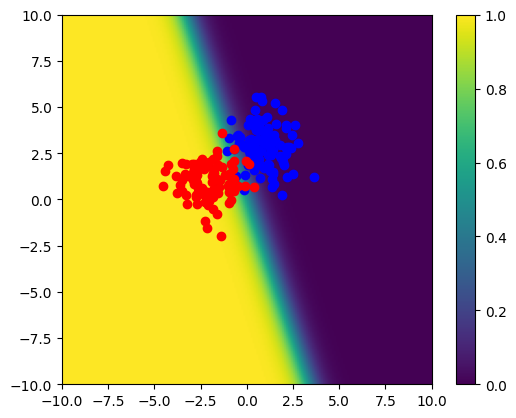

In [97]:
plot_classifier(steps[-1], cats, dogs, extent=extent)

## Gradient descent

As discussed in the introduction, the main tool in this learning algorithm is the gradient descent: given a function $\ell : \mathbb{R}^3 \to \mathbb{R}_{\geq 0}$ we would like to find a point $\theta \in \mathbb{R}^3$ for which the value $\ell(\theta)$ is as small as possible. We will do it using an iterative procedure: in each step we will move $\theta$ a little bit in the direction in which $\ell$ is locally decreasing fastest.

As it turns out, such a direction (negative gradient) can be deduced from derivatives of the function $\ell$; just as with univariate derivatives, if the function $\ell$ is given to us as a formula, we can compute its gradient essentially algorithmically, by iteratively applying a chain rule (as a reminder: a univariate chain rule is just $f(g(x))' = f'(g(x)) g'(x)$), product rule, etc.

The gradient of a function $\ell$ is usually denoted by $\nabla \ell$, and it is a function $\nabla \ell : \mathbb{R}^3 \to \mathbb{R}^3$ --- it maps each point to a vector: a direction in which the function is increasing the fastest.

We will implement and visualize gradient descent in $2$ dimensions instead, since it is cleaner to show on the screen than $3$ dimensions. Exactly the same ideas will apply on $3$ (and then in $n$ dimension) - altough there are some essential qualitative differences for many phenomena between low and high-dimensional regimes.

**Example**
We can first look at a function $\ell(x_1, x_2) = x_1^2 + x_2^2$, and draw $-\nabla f$, at various points:

In [98]:
def sq_dist_from_origin(x):
    return x.dot(x)
def grad_sq_dist_from_origin(x):
    return 2 * x

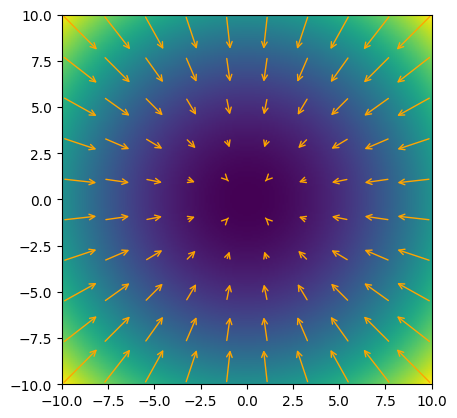

In [99]:
visualize_gradient_descent(np.array([-5., -5.]), 
                           extent, 
                           sq_dist_from_origin, grad_sq_dist_from_origin, 
                           iters=300, show_descent=False,
                          grad_scale = 0.1)

At each point, the function is fastest-decreasing if we move towards the origin. The direction of the (negative) gradient is indicating in which direction the function is fastest-decreasing, and the magnitute - how fast the function is decreasing in this direction.

Note that this is similar to what happens with a simple univariate derivative of a function $f : \mathbb{R} \to \mathbb{R}$ with which you are familiar - except for the fact that there are only two possible directions on the line: to the left or to the right. In this case, the sign of the derivative tells us in which of the two directions the function is increasing, and the magnitude: how fast it is decreasing in this direction.

**Gradient descent**
Let us now see what happens with the gradient descent on this example. We start with a point $\theta = (-5., -6.)$, and in each step move a little bit in the direction of the negative gradient of $\ell$ at $\theta$. Since $\ell$ is simple quadratic function, $-\nabla \ell(\theta)$ is just pointing towards the center:

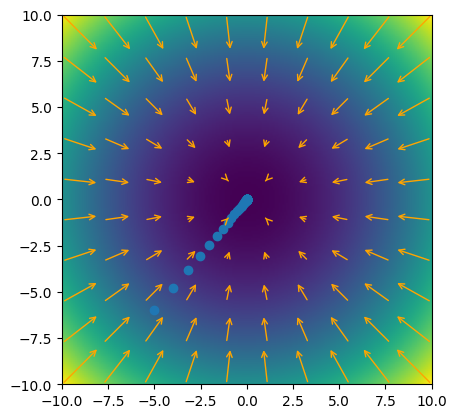

In [100]:
visualize_gradient_descent(np.array([-5., -6.]), 
                           extent, 
                           sq_dist_from_origin, grad_sq_dist_from_origin, 
                           iters=300, show_descent=True,
                          grad_scale = 0.1)

### Side note: convexity
The gradient descent quite quickly converges towards $0$ --- the global minimum of $\ell(x_1, x_2) = x_1^2 + x_2^2$. The reason for this is that function $\ell$ above is _convex_. 

You can easily intuitively see the notioon of convexity for a univariate function $f :\mathbb{R} \to \mathbb{R}$: a function like this is convex, if if we connect any two points on the graph of $f$ with a line, the entire line is above (or touching) the graph of $f$.

For instance, you can easily convince yourself that $f(x) = x^2$ is convex, but $f(x) = x^3$ isn't, by just looking at the plots of both those functions.

In higher dimension, we say that a function $f : \mathbb{R}^n \to \mathbb{R}$ is convex if for any two points $x, y \in \mathbb{R}^n$, and any $\lambda \in [0, 1]$ we have $\lambda f(x) + (1-\lambda)f(y) \geq f(\lambda x + (1-\lambda) y)$. You can convince yourself, that this is equivalent to the above notion: the entire line segment connecting two points of the graph of $f$ is above the actual graph of $f$.

The notion of convexity, especially in high dimensions, turns out to be extremely important in mathematics for multilpe reasons. Not least of which is the fact that every local minimum of a convex function is already a global minimum (there is "essentially" only one local minimum), and under mild conditions we can show that gradient descent will converge to this local minimum.

### How to calculate the gradient
Why the negative gradient of the function $\ell(x_1, x_2) = x_1^2 + x_2^2$ is pointing towards the origin? It turns out that to calculate the coordinates of the gradient vector $\nabla \ell (x_1, x_2)$, we can use familiar rules for differentiation: the first coordinate just correspond to fixing $x_2$ (treating it as a constant, and) looking at a univariate derivate of $f(x_1) = x_1^2 + x_2^2$. Clearly $f'(x_1) = 2 x_1$ --- since $x_2^2$ here should be thought of as a constant, the derivative here with respect to $x_1$ is zero; the derivative of $x_1^2$ with respect to $x_1$ is $2 x_1$.

Similarly, to get the second coordinate of the gradient, we treat $x_1$ as constant, and calculate derivatives with respect to $x_2$. We get that the second coordinate is $2 x_2$, and finally th whole gradient of $\ell$ at $(x_1, x_2)$ is a vector with coordinates
$$
\nabla \ell(x_1, x_2) = (2 x_1, 2 x_2).
$$

We want to look at negative gradient: $-\nabla \ell(x_1, x_2) = (-2 x_1, -2x_2)$ --- indeed at every point $x$ it is a vector that is pointing towards $0$.

### Nonconvex example
We can look at a different, more complicated example - a nonconvex function, to see an example with several local minima, and a more complicated structure of the gradient.

The function is given as:
$$
\ell(\mathbf{x}) = h(\|x - c_1\|_2) + h(\|x - c_2\|_2) + h(\|x - c_3\|_2) 
$$
where $\mathbf{c}_1 := (3, -4), \mathbf{c}_2 := (1,3), \mathbf{c}_3(-2, 5)$, and 
$$
h(t) := \begin{cases*} t & $|t| < 1$ \\ \sqrt{t} & otherwise \end{cases*}$$

In [101]:
centers = np.array([(3, -4), (1, 3), (-2, 5)])

def H(t):
    if abs(t) < 1:
        return t
    else:
        return math.sqrt(abs(t))

def my_fun(x):
    result = 0
    for p in centers:
        result += H( np.linalg.norm(x - p) )
    return result

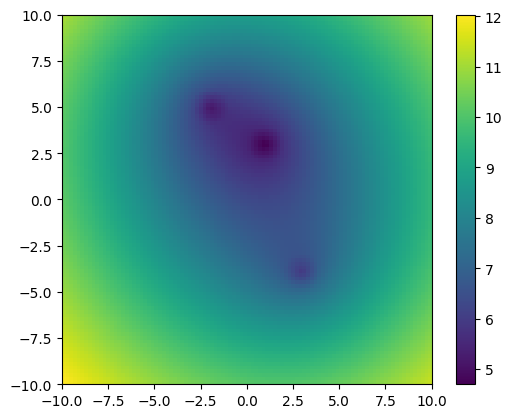

In [102]:
plot_2d_func(my_fun, extent=extent, N = 100)
plt.colorbar()

To calculate gradient of this $f$, we just apply the linearity $\nabla(f+g)(x) = \nabla f(x) + \nabla g(x)$ and the multivariate version of the chain rule: for $f: \mathbb{R} \to \mathbb{R}$ and $g : \mathbb{R}^n \to \mathbb{R}$ we have
$$
\nabla f(g(x)) = f'(g(x)) \nabla g(x).
$$

(Note that this is a vector: $\nabla g(x)$ is a vector and $f'(g(x))$ is a scalar.) 

Computing derivative of $h$ is a simple exercise in univariate calculus.

In [103]:
def d_H(x):
    if abs(x) < 1:
        return 1
    else:
        return 1 / (2 * math.sqrt(abs(x)))

def grad_my_fun(x):
    result = np.zeros(2)
    for p in centers:
        result += d_H( np.linalg.norm(x-p)) *  (x-p) / np.linalg.norm(x-p)
    return result

We can visualize now the directiosn of the gradient at various points - close to a local minimum it is point in its direction.

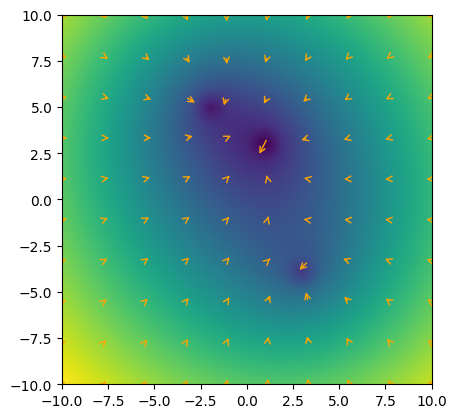

In [104]:
visualize_gradient_descent(np.array([-5., -5.]), extent, my_fun, grad_my_fun, iters=300, show_descent=False, grad_scale=1.)

We can also look at trajectories of gradient descent, starting from various positions, and see how it converges to different local minima.

**Starting from (-5, -5)**

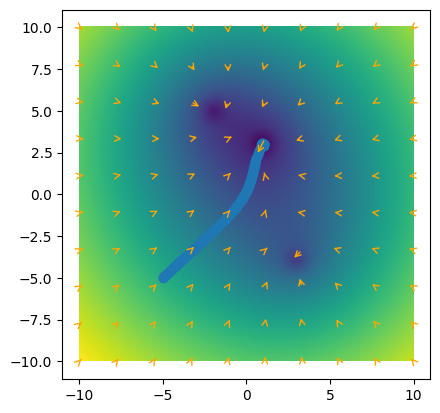

In [106]:
visualize_gradient_descent(np.array([-5., -5.]), extent, my_fun, grad_my_fun, iters=300, show_descent=True, grad_scale=1.)

**Starting from (-9, 3)**

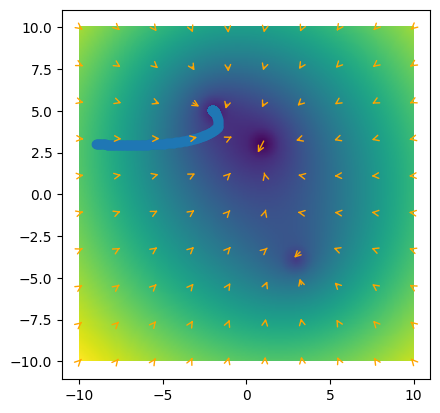

In [107]:
visualize_gradient_descent(np.array([-9., 3.]), extent, my_fun, grad_my_fun, iters=300, show_descent=True, grad_scale=1.)

**Starting from (9, -4)**

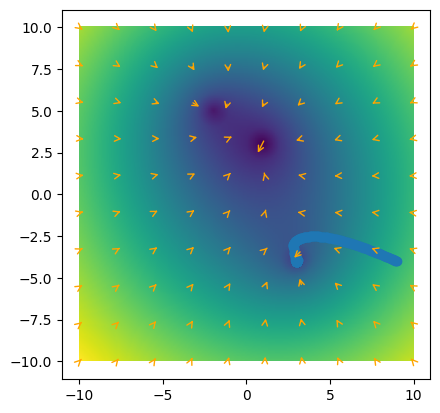

In [108]:
visualize_gradient_descent(np.array([9., -4]), extent, my_fun, grad_my_fun, iters=500, show_descent=True, grad_scale=1.)

## Gradient descent implementation

After this entire discussion, the core of the learning process --- the famous gradient descent algorithm --- is actually very simple to implement.

We have a function `gradient_descent` that takes as an argument some initial position $\theta_0$, a `gradient_fun` --- a function that takes as an input a point $\theta$ and returns a gradient vector $\nabla \ell(\theta)$, as well as a parameter $\mu$ (so-called _learning rate_), and number of iteration `iters`. The algorithm just repeats a gradient step `iters` time. Starting with $\theta_0$ being the subsequent  points it visits are:
$$
\theta_{k+1} = \theta_k -  \mu \nabla \ell(\theta_k)
$$

That is: in the $k$-th step, we calculate the gradient vector at this specific point $\theta$, and move a little bit in the direction of $- \nabla \ell(\theta)$ --- the $\mu$ parameter (small constant, like 0.01) governs how much we move in the direction of the negative gradient. 

**Learning rate $\mu$**
Chosing the right $\mu$ in general is a bit of magic in itself (too small one, and the convergence is extremely slow; too large one, and the algorithm might not converge at all, jumping too far and "overshooting" the local minimum back and forth) - we will not discuss it here, and just try a few numbers until one looks nice

Our function `gradient_descent` returns the list of all positions visited by the gradient descent (all $\theta_k$) - we can use those for example to visualize the progression of the algorithm, or how the actual loss changed over the descent

In [109]:
def gradient_descent(initial_pos, gradient_fun, mu = 0.1, iters = 100):
    pos_list = []
    current_pos = initial_pos.copy()
    for i in range(iters):
        pos_list.append(current_pos.copy())
        current_pos -= mu * gradient_fun(current_pos)
    return np.array(pos_list)

The `visualize_gradient_descent` function we were using above was basically just calling `plot_2d_function`, and overlaying all of the steps of gradient descent:

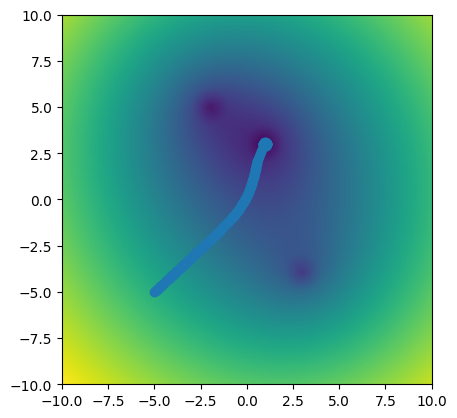

In [111]:
initial_theta = np.array([-5., -5.])
positions = gradient_descent(initial_pos=initial_theta, gradient_fun=grad_my_fun, mu=0.1, iters=500)
plot_2d_func(my_fun, extent=extent, N = 300)
plt.scatter(positions[:, 0], positions[:, 1])

A little bit of the extra coder in the `visualize_gradient_descent` function is used to draw all the arrows for points of the gradient.

# Additional functions
Here I provide the remaining code used to generate all the plots in this lecture, without further comments. Most of it - code responsible for the solution of the 2d-learining problem by finding the best line-separator, using the gradient descent algorithm will be explained in more details in the next lecture.

## Visualization functions

In [1]:
from matplotlib.patches import FancyArrowPatch

In [2]:
def plot_2d_func(fun, extent, N=30, ax = None):
    x_min, x_max, y_min, y_max = extent
    xx = np.linspace(x_min, x_max, num=N)
    yy = np.linspace(y_min, y_max, num = N)
    img = np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(N):
            img[i,j] = fun(np.array([xx[j], yy[i]]))
    if ax is None:
        plt.imshow(img, extent=extent, origin='lower')
    else:
        ax.imshow(img, extent=extent, origin='lower')

In [3]:
def visualize_gradient_descent(initial_pos, extent, fun, dfun, iters=100, show_descent = True, grad_scale = 0.5):
    x_min, x_max, y_min, y_max = extent
    fig, ax = plt.subplots()

    plot_2d_func(fun, extent=extent, N=200, ax = ax)
    
    if show_descent:
        steps = np.array(gradient_descent( initial_pos, dfun, iters = iters))
        ax.scatter(steps[:, 0], steps[:, 1])
    
    xx_s = np.linspace(x_min, x_max, num=10)
    yy_s = np.linspace(y_min, y_max, num=10)
    
    for i in range(len(xx_s)):
        for j in range(len(yy_s)):
            pos = np.array([xx_s[i], yy_s[j]])
            ngrad = dfun(pos)
            dest = pos - grad_scale*ngrad
            
            arrow = FancyArrowPatch(posA = pos, posB = dest, arrowstyle='->', mutation_scale=10, color="orange")
            ax.add_patch(arrow)

## Learning problem

In [28]:
def loss(x, y):
    return (x-y)**2

def d_loss(x, y):
    return 2*(x-y)

In [29]:
def sigmoid(x):
    return np.exp(x) / ( 1 + np.exp(x) )

def d_sigmoid(x):
    return np.exp(x) / (1 + np.exp(x) )**2

In [30]:
def classifier(x, theta):
    val = x.dot(theta[:-1]) + theta[-1]
    return sigmoid(val)

def grad_classifier(x, theta):
    val = x.dot(theta[:-1]) + theta[-1]
    return d_sigmoid(val) * np.concat( ( x, [1]) )

In [31]:
def total_loss(dataset, theta):
    result = 0
    for x, y in dataset:
        result += loss(f(x, theta), y)
    return result

In [32]:
def grad_total_loss(dataset, theta):
    result = np.zeros(3)
    for x,y in dataset:
        result += grad_classifier(x, theta) * d_loss(classifier(x, theta), y)
    return result

## Gradient descent

In [33]:
def gradient_descent(initial_pos, gradient_fun, mu = 0.1, iters = 100):
    pos_list = []
    current_pos = initial_pos.copy()
    for i in range(iters):
        pos_list.append(current_pos.copy())
        current_pos -= mu * gradient_fun(current_pos)
    return np.array(pos_list)